# AAI-540 Group 6 Final Project

Authors: Alden Caterio, Gary Takahashi, Paul Parks

In [1]:
%pip install --disable-pip-version-check -q PyAthena
%pip install --disable-pip-version-check -q awswrangler
%pip install -q wordcloud
%pip install -q -U seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports

In [2]:
import os
import pandas as pd
import numpy as np
import boto3
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role
from time import gmtime, strftime, time
from botocore.client import ClientError
from pyathena import connect
import pandas as pd
import boto3
import sagemaker
import awswrangler as wr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## AWS S3 and Athena Setup

### Collect a raw data set and store it in an S3 Datalake.

In [3]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)

print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-019877554860


In [4]:
response = None
try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print("[ERROR] Cannot find bucket {} in {} due to {}.".format(bucket, response, e))

{'ResponseMetadata': {'RequestId': 'G3TQ5NKJ2MW1E7VR', 'HostId': 'DVZFKZeu5p+stZPP4oK9Tn/DcUxThu1+PKGfPJNO5UR92m3WP0t6iE6T6TQhdB/16taWIB+kLPOFgFg9r63zWg==', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'DVZFKZeu5p+stZPP4oK9Tn/DcUxThu1+PKGfPJNO5UR92m3WP0t6iE6T6TQhdB/16taWIB+kLPOFgFg9r63zWg==', 'x-amz-request-id': 'G3TQ5NKJ2MW1E7VR', 'date': 'Sun, 13 Oct 2024 04:24:20 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'BucketRegion': 'us-east-1', 'AccessPointAlias': False}


In [5]:
filename = 'CEAS_08.csv'
#local_csv_path = './dataset/' + filename
local_csv_path = 'dataset/CEAS_08.csv'

parquet_filename = filename.replace('.csv', '.parquet')  # Parquet file name
local_parquet_path = os.path.join('./dataset/', parquet_filename)

df = pd.read_csv(local_csv_path)
# Convert the CSV to Parquet
df['urls'] = df['urls'].astype(str)
df['label'] = df['label'].astype(int)  # Convert 'label' column to integer
df = df.drop(["receiver","date","urls"], axis=1)
df.to_parquet(local_parquet_path, engine='pyarrow')

folder_in_s3 = 'Dataset/'
s3_destination_path = f's3://{bucket}/{folder_in_s3}{parquet_filename}'
s3_destination_dir = f's3://{bucket}/{folder_in_s3}'

s3 = boto3.client('s3')

bucket_name = bucket
key = f'{folder_in_s3}{parquet_filename}'

s3.upload_file(local_parquet_path, bucket_name, key)

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=key)
if 'Contents' in response:
    print(f"File '{local_parquet_path}' uploaded successfully to '{s3_destination_path}'")
else:
    print(f"Failed to upload file to {s3_destination_path}")

File './dataset/CEAS_08.parquet' uploaded successfully to 's3://sagemaker-us-east-1-019877554860/Dataset/CEAS_08.parquet'


In [6]:
df.head()

,sender,subject,body,label
0,Young Esposito <Young@iworld.de>,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1
1,Mok <ipline's1983@icable.ph>,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


### Set up Athena tables to enable cataloging and querying of your data.

In [7]:
database_name = "spam_detection_db"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

/tmp/ipykernel_3677/4249963361.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [8]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_3677/1677879827.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,default
1,hw2
2,hw2_1
3,sagemaker_featurestore
4,spam_detection_db


In [9]:
table_name = "emails"
statement = f"""DROP TABLE IF EXISTS {database_name}.{table_name}"""
pd.read_sql(statement, conn)

/tmp/ipykernel_3677/3526594799.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [10]:
database_name = 'spam_detection_db'
table_name = 'emails'
s3_location = 's3://sagemaker-us-east-1-019877554860/Dataset'

statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}
(
    sender STRING,
    subject STRING,
    body STRING,
    label INT
)
STORED AS PARQUET
LOCATION '{s3_location}'
"""

pd.read_sql(statement, conn)

/tmp/ipykernel_3677/2187016979.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [11]:
statement = f"SHOW TABLES in {database_name}"

df_show = pd.read_sql(statement, conn)
print(df_show.head(5))

if table_name in df_show.values:
    print("[OK] Table created successfully.")
else:
    print("[ERROR] Table creation failed.")

/tmp/ipykernel_3677/1698154721.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


  tab_name
0   emails
[OK] Table created successfully.


In [12]:
statement = f"""SELECT COUNT(*) AS total_rows
FROM {database_name}.{table_name}"""

result = pd.read_sql(statement, conn)
result.head(5)

/tmp/ipykernel_3677/1710626760.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(statement, conn)


,total_rows
0,39154


In [13]:
statement = f"""SELECT * FROM {database_name}.{table_name} LIMIT 10"""

result = pd.read_sql(statement, conn)
result.head(10)

/tmp/ipykernel_3677/1869399943.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(statement, conn)


,sender,subject,body,label
0,Young Esposito <Young@iworld.de>,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1
1,Mok <ipline's1983@icable.ph>,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1
5,Caroline Aragon <dwthaidomainnamesm@thaidomain...,From Caroline Aragon,\n\n\n\n\nYo wu urS mo ou go rc ebo eForM rgi ...,1
6,Replica Watches <jhorton@thebakercompanies.com>,Replica Watches,We have fake Swiss Men's and Ladie's Replica \...,1
7,Daily Top 10 <acidirev_1972@tcwpg.com>,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
8,qydlqcws-iacfym@issues.apache.org,[Bug 5780] URI processing turns uuencoded stri...,http://issues.apache.org/SpamAssassin/show_bug...,0
9,Daily Top 10 <orn|dent_1973@musicaedischi.it>,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1


## AWS FeatureStore

### Test Train Split
Split your feature data into training (~40%), test (~10%) validation (~10%) datasets.
Reserve some data for “production data” (~40%).

In [14]:
feature_store_data = wr.athena.read_sql_query(f"SELECT * FROM {database_name}.{table_name}", database=database_name)

2024-10-13 04:24:41,804	WARNING services.py:2009 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 411021312 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.90gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-10-13 04:24:43,068	INFO worker.py:1771 -- Started a local Ray instance.


In [15]:
# Set up AWS clients and SageMaker session
boto_session = boto3.Session()
region = boto_session.region_name
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(service_name="sagemaker-featurestore-runtime", region_name=region)
feature_store_session = Session(boto_session=boto_session, sagemaker_client=sagemaker_client, sagemaker_featurestore_runtime_client=featurestore_runtime)

# Define the S3 bucket for the offline store
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = "sagemaker-featurestore-spamdetection"

# Set up IAM role for SageMaker
role = get_execution_role()

In [16]:
# Create a FeatureGroup for the data
spamdetection_feature_group_name = "spamdetection-feature-group" + strftime("%d-%H-%M-%S", gmtime())
spamdetection_feature_group = FeatureGroup(name=spamdetection_feature_group_name, sagemaker_session=feature_store_session)

# Cast necessary columns to the right types
def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")

cast_object_to_string(feature_store_data)

In [17]:
from time import sleep
import uuid
current_time_sec = int(time())

feature_store_data['primary_key'] = [str(uuid.uuid4()) for _ in range(len(feature_store_data))]
feature_store_data['event_time'] = pd.Series([current_time_sec] * len(feature_store_data), dtype='float64')

# Record identifier and event time feature names
record_identifier_feature_name = 'primary_key'
event_time_feature_name = 'event_time'

# Load feature definitions from the DataFrame
spamdetection_feature_group.load_feature_definitions(data_frame=feature_store_data)

# Create the FeatureGroup in the SageMaker FeatureStore
spamdetection_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)


# Wait for the FeatureGroup to be created
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

wait_for_feature_group_creation_complete(feature_group=spamdetection_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup spamdetection-feature-group13-04-24-46 successfully created.


## Exploratory Data Analysis

In [18]:
df = feature_store_data

In [19]:
# Display the first few rows of the dataset
df.head()

,sender,subject,body,label,primary_key,event_time
0,Young Esposito <Young@iworld.de>,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,22f19e68-2c96-4423-b994-7d9a43d3b8e0,1.728793e+09
1,Mok <ipline's1983@icable.ph>,Befriend Jenna Jameson,Upgrade your sex and pleasures with these tec...,1,3f5cd8bf-5a96-4589-bb8d-39a2f1bfdb17,1.728793e+09
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,a58d4d15-2ad5-4a6b-b5cb-d6e84fa11e6b,1.728793e+09
3,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,d751d1f8-4655-4427-b781-2289bc8e7a2b,1.728793e+09
4,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iw...,1,c203932a-7b25-4996-b505-95ad4c62a48e,1.728793e+09


In [20]:
# Get the shape of the dataset (number of rows and columns)
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 39154 rows and 6 columns.


In [21]:
# Get information about data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sender       39154 non-null  string 
 1   subject      39126 non-null  string 
 2   body         39154 non-null  string 
 3   label        39154 non-null  Int32  
 4   primary_key  39154 non-null  object 
 5   event_time   39154 non-null  float64
dtypes: Int32(1), float64(1), object(1), string(3)
memory usage: 1.7+ MB


In [22]:
# Get statistical summary of numerical columns
df.describe()

,label,event_time
count,39154.0,3.915400e+04
mean,0.557848,1.728793e+09
std,0.496649,0.000000e+00
min,0.0,1.728793e+09
25%,0.0,1.728793e+09
50%,1.0,1.728793e+09
75%,1.0,1.728793e+09
max,1.0,1.728793e+09


In [23]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
sender          0
subject        28
body            0
label           0
primary_key     0
event_time      0
dtype: int64


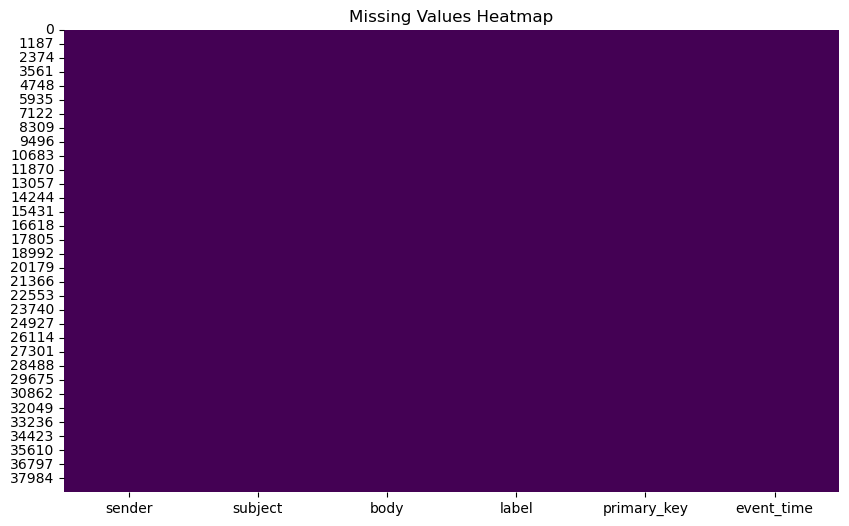

In [24]:
# Visualize missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [25]:
# Get the distribution of the target variable 'label'
label_counts = df['label'].value_counts()
print("Distribution of target variable 'label':")
print(label_counts)

Distribution of target variable 'label':
label
1    21842
0    17312
Name: count, dtype: Int64


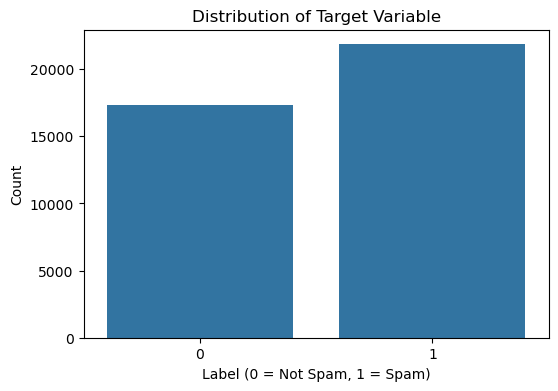

In [26]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Label (0 = Not Spam, 1 = Spam)')
plt.ylabel('Count')
plt.show()

In [27]:
# Check the number of unique senders and receivers
num_senders = df['sender'].nunique()
print(f"Number of unique senders: {num_senders}")

Number of unique senders: 24578


In [28]:
# Top 10 most frequent senders
top_senders = df['sender'].value_counts().head(10)
print("Top 10 senders:")
print(top_senders)

Top 10 senders:
sender
qydlqcws-iacfym@issues.apache.org                 462
Guido van Rossum <hoauf@python.org>               295
"\\"Martin v. Löwis\\"" <qpnysl@v.loewis.de>      276
"Carlos E. R." <vyjwd.trpcau@telefonica.net>      208
Aaron Kulkis <cmiqlkx91@hotpop.com>               183
Rafael Garcia-Suarez <pvhuhqgncrxnu@gmail.com>    158
Christian Heimes <wluhe@cheimes.de>               152
Barry Warsaw <pjaxq@python.org>                   131
iybz@pobox.com                                    124
Per Jessen <uee@computer.org>                     113
Name: count, dtype: Int64


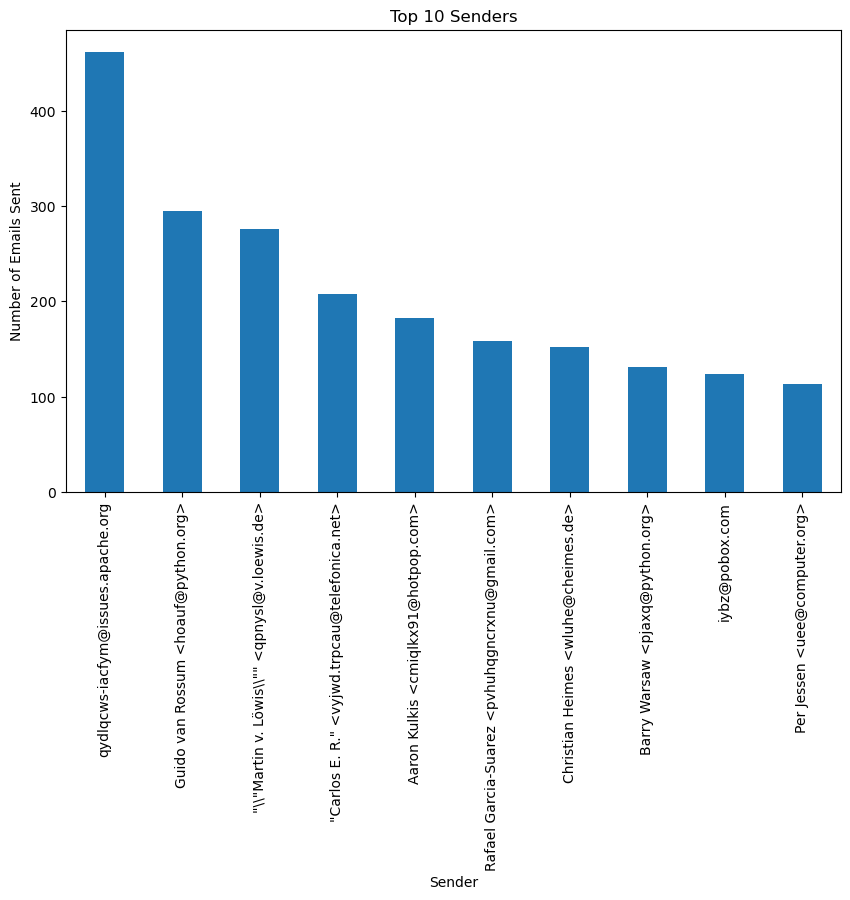

In [29]:
# Visualize top senders
plt.figure(figsize=(10, 6))
top_senders.plot(kind='bar')
plt.title('Top 10 Senders')
plt.xlabel('Sender')
plt.ylabel('Number of Emails Sent')
plt.show()

In [30]:
# Create new features for the lengths of text fields
df['subject_length'] = df['subject'].astype(str).apply(len)
df['body_length'] = df['body'].astype(str).apply(len)

In [31]:
# Statistical summary of the text lengths
text_length_summary = df[['subject_length', 'body_length']].describe()
print("Statistical summary of text lengths:")
print(text_length_summary)

Statistical summary of text lengths:
       subject_length    body_length
count    39154.000000   39154.000000
mean        38.899397    1571.079813
std         20.764513    3615.810576
min          1.000000      14.000000
25%         25.000000     224.000000
50%         35.000000     570.000000
75%         50.000000    1643.000000
max        285.000000  143996.000000


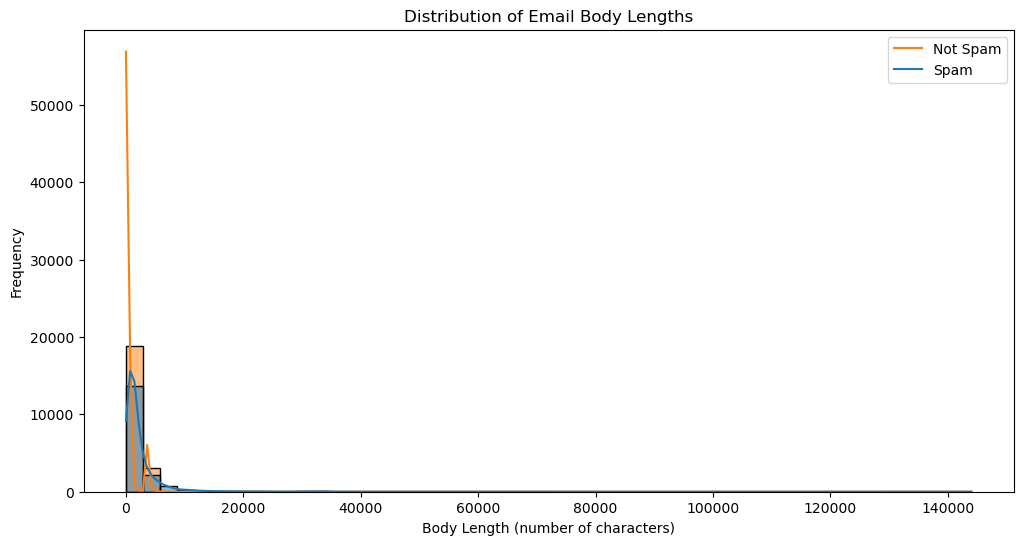

In [32]:
# Visualize the distribution of body lengths for spam and non-spam emails
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='body_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Email Body Lengths')
plt.xlabel('Body Length (number of characters)')
plt.ylabel('Frequency')
plt.legend(labels=['Not Spam', 'Spam'])
plt.show()

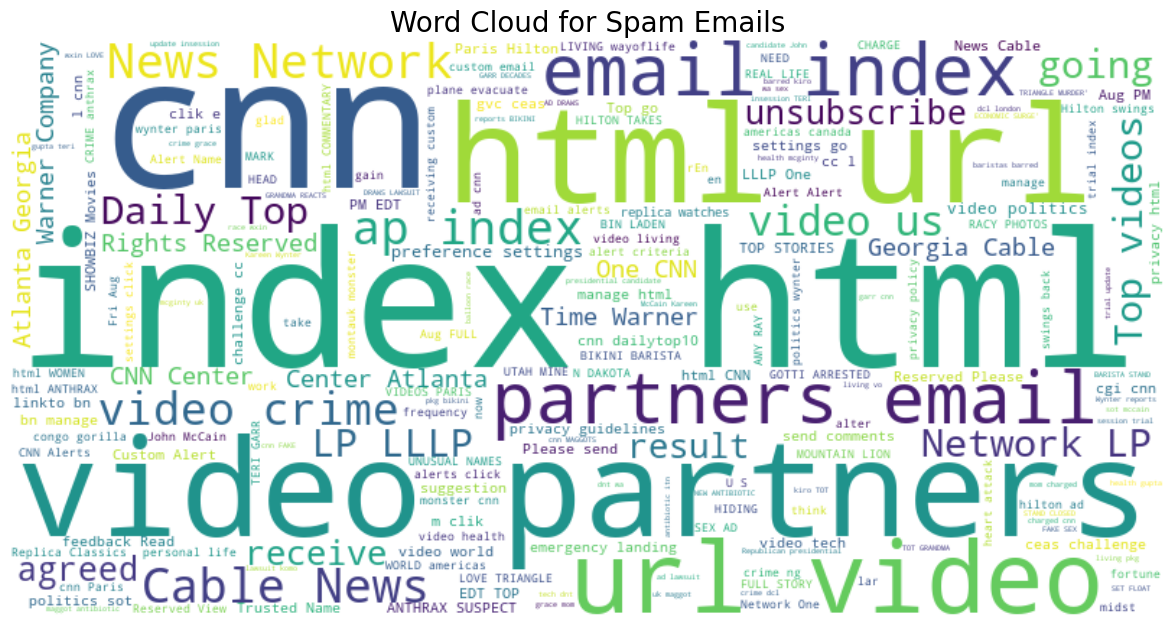

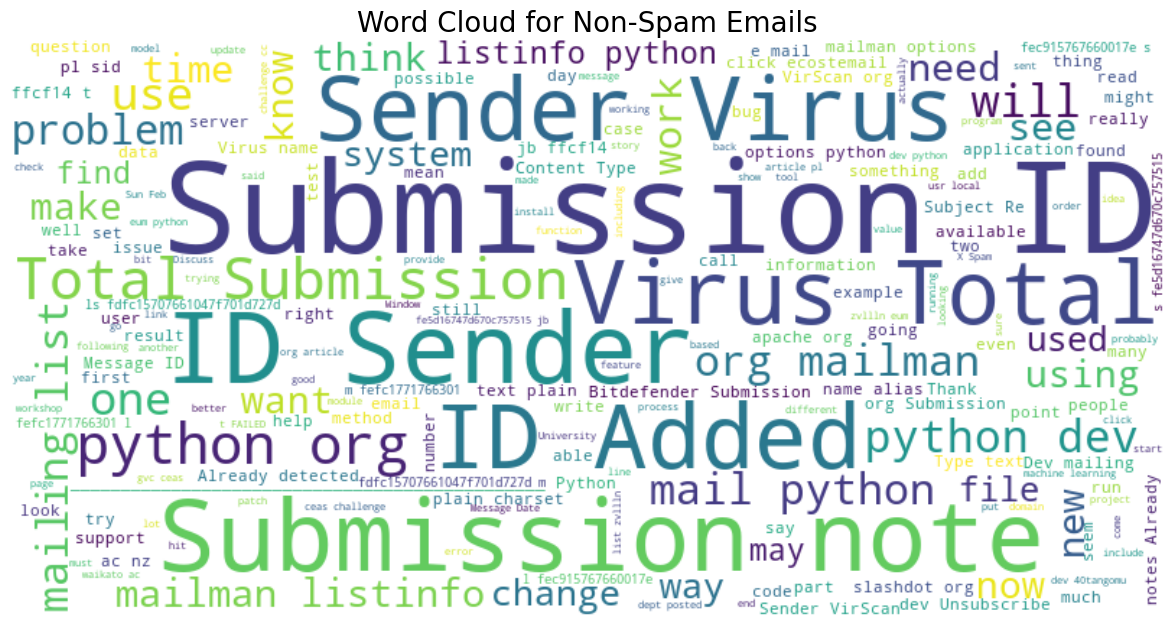

In [33]:
# Generate word clouds for spam and non-spam emails
spam_emails = df[df['label'] == 1]
non_spam_emails = df[df['label'] == 0]

def generate_wordcloud(text_data, title):
    text = ' '.join(text_data.dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Word cloud for spam emails
generate_wordcloud(spam_emails['body'], 'Word Cloud for Spam Emails')

# Word cloud for non-spam emails
generate_wordcloud(non_spam_emails['body'], 'Word Cloud for Non-Spam Emails')

In [34]:
# Create a DataFrame with numerical features
numerical_features = ['subject_length', 'body_length']
numerical_df = df[numerical_features + ['label']]

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
                subject_length  body_length     label
subject_length        1.000000     0.063805 -0.393957
body_length           0.063805     1.000000 -0.239108
label                -0.393957    -0.239108  1.000000


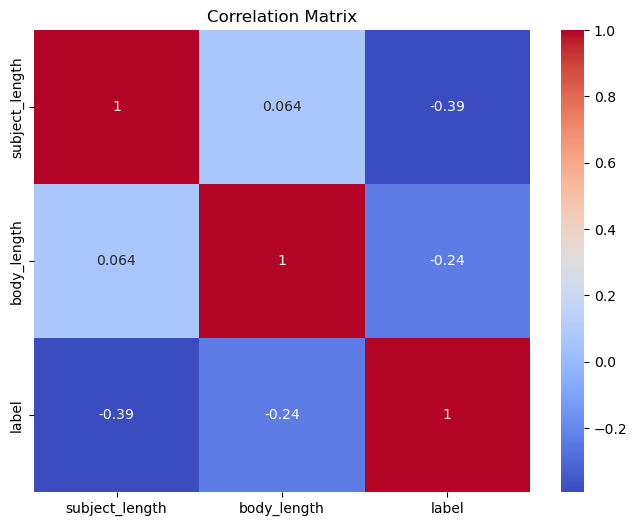

In [35]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Model

In [36]:
# keep the original dataset untampered
# only using 10000 rows for now because kernel keeps crashing
df_new = df

# Combine subject and body
df_new['text'] = df_new['subject'] + ' ' + df_new['body']

In [37]:
df_new.head()

,sender,subject,body,label,primary_key,event_time,subject_length,body_length,text
0,Young Esposito <Young@iworld.de>,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,22f19e68-2c96-4423-b994-7d9a43d3b8e0,1.728793e+09,25,273,"Never agree to be a loser Buck up, your troubl..."
1,Mok <ipline's1983@icable.ph>,Befriend Jenna Jameson,Upgrade your sex and pleasures with these tec...,1,3f5cd8bf-5a96-4589-bb8d-39a2f1bfdb17,1.728793e+09,22,82,Befriend Jenna Jameson Upgrade your sex and p...
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,a58d4d15-2ad5-4a6b-b5cb-d6e84fa11e6b,1.728793e+09,20,3918,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
3,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,d751d1f8-4655-4427-b781-2289bc8e7a2b,1.728793e+09,150,24418,Re: svn commit: r619753 - in /spamassassin/tru...
4,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iw...,1,c203932a-7b25-4996-b505-95ad4c62a48e,1.728793e+09,26,175,SpecialPricesPharmMoreinfo WelcomeFastShippin...


In [38]:
# Splitting 80% for training, 10% for testing, 10% for validation
df_production, df_train = train_test_split(df_new, test_size=0.80, random_state=42)
df_test, df_validation = train_test_split(df_production, test_size=0.50, random_state=42)

# Print the sizes of each split to confirm
print(f"Training data: {len(df_train)} rows")
print(f"Test data: {len(df_test)} rows")
print(f"Validation data: {len(df_validation)} rows")
print(f"Production data: {len(df_production)} rows")

Training data: 31324 rows
Test data: 3915 rows
Validation data: 3915 rows
Production data: 7830 rows


In [39]:
# Save the training data to CSV
df_train[['label', 'text']].to_csv('train.csv', index=False)

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

prefix = 'benchmark-model'

train_input_path = sagemaker_session.upload_data('train.csv', bucket=bucket, key_prefix=f'{prefix}/train')

print(f'Training data uploaded to: {train_input_path}')

Training data uploaded to: s3://sagemaker-us-east-1-019877554860/benchmark-model/train/train.csv


### Train script
the following script will be output and used by the estimator

In [40]:
%%writefile train.py

import argparse
import os
import pandas as pd
import joblib

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer

def model_fn(model_dir):
    """Load the model for inference"""
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    vectorizer = joblib.load(os.path.join(model_dir, "vectorizer.joblib"))
    return model, vectorizer

def predict_fn(input_data, model_and_vectorizer):
    """Vectorize string input and make predictions"""
    model, vectorizer = model_and_vectorizer
    
    # Check if the input data is a string (email body)
    # Transform the input string to TF-IDF features
    input_tfidf = vectorizer.transform([str(input_data)])
    input_dense = input_tfidf.toarray()  # Convert to dense format for GaussianNB

    # Make predictions using the trained model
    prediction = model.predict(input_dense)
    
    return prediction

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # SageMaker-specific arguments
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    
    args = parser.parse_args()
    
    # Read the training data
    train_data = pd.read_csv(os.path.join(args.train, 'train.csv'))
    
    # Separate features and target
    X_train = train_data['text'].astype(str)
    y_train = train_data['label']
    
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=10000)    
    X_train_tfidf = vectorizer.fit_transform(X_train)
   
    # Convert sparse matrix to dense for GaussianNB
    X_train_dense = X_train_tfidf.toarray()
    
    # Train the model
    # Build a Naive Bayes Classifier
    model = GaussianNB()
    
    model.fit(X_train_dense, y_train)
    
    # Save the model
    joblib.dump(model, os.path.join(args.model_dir, "model.joblib"))
    joblib.dump(vectorizer, os.path.join(args.model_dir, "vectorizer.joblib"))


Overwriting train.py


### Train the model

In [41]:
from sagemaker.sklearn.estimator import SKLearn

role = sagemaker.get_execution_role()

sklearn_estimator = SKLearn(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='0.23-1',
    py_version='py3',
    output_path=f's3://{bucket}/{prefix}/output'
)

# Run the training job
sklearn_estimator.fit({'train': train_input_path})

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-10-13-04-25-53-679


2024-10-13 04:25:55 Starting - Starting the training job...
2024-10-13 04:26:09 Starting - Preparing the instances for training...
2024-10-13 04:26:51 Downloading - Downloading the training image...
2024-10-13 04:27:22 Training - Training image download completed. Training in progress...2024-10-13 04:27:33,049 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-10-13 04:27:33,052 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-13 04:27:33,093 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-10-13 04:27:33,275 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-13 04:27:33,287 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-13 04:27:33,298 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-13 04:27:33,307 sagemaker-training-toolkit INFO     Invoking user

## Deploy the trained model

In [42]:
from datetime import datetime, timedelta, timezone

# define endpoint name
endpoint_name = f"naivebayes-spam-detection-model-quality-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

EndpointName = naivebayes-spam-detection-model-quality-monitor-2024-10-13-0428


In [43]:
# Deploy the model to an endpoint
predictor = sklearn_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    endpoint_name=endpoint_name   # Adding endpoint name for model monitoring purposes
)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-10-13-04-28-41-413
INFO:sagemaker:Creating endpoint-config with name naivebayes-spam-detection-model-quality-monitor-2024-10-13-0428
INFO:sagemaker:Creating endpoint with name naivebayes-spam-detection-model-quality-monitor-2024-10-13-0428


-----!

### Test Inference

In [44]:
test_email_subject = "Test Email"
test_email_body = "Hi this is not spam I promise"
test_email = test_email_subject + ' ' + test_email_body
print(predictor.predict(str(test_email)))

[1]


In [45]:
test_email_subject = "Project docs"
test_email_body = "I will send you the project doc later today"
test_email = test_email_subject + ' ' + test_email_body
print(predictor.predict(str(test_email)))

[0]


### Run inference for evaluation

In [46]:
# Prepare test data
df_test.dropna(inplace=True)
X_test = df_test['text']
y_test = df_test['label']

In [47]:
# Set the serializer and deserializer
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Make predictions
predicted_labels = []
for email_body in X_test:
    prediction = predictor.predict(str(email_body))
    predicted_labels.append(int(prediction[0]))

# Compare predictions with actual labels
print(predicted_labels[0:20])

[0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]


## Evaluation

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print("Benchmark Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Benchmark Model Performance:
Accuracy: 0.9852
Precision: 0.9986
Recall: 0.9742
F1 Score: 0.9862


## Monitoring

In [49]:
df_validation.head()

,sender,subject,body,label,primary_key,event_time,subject_length,body_length,text
1946,Hans Linux <ramy.jsnsv@igi-alliance.com>,[opensuse] Camorama error,"I hv an error with camorama, dont know how to ...",0,bad66938-ae90-41f6-9797-e9bec1038a51,1.728793e+09,25,265,[opensuse] Camorama error I hv an error with c...
15515,Rosario Cleveland <Rosario@everblue.ch>,Love tool deserving of a titan!,The dimension of your love luger calls for sub...,1,92b44f90-bcca-4691-9516-a05bf6b3cd9d,1.728793e+09,32,288,Love tool deserving of a titan! The dimension...
6691,Martin List-Petersen <qpnysl@list-petersen.dk>,Re: [ILUG] Broadband in Dublin,"FRLinux wrote: > On 10/8/07, Martin List-Peter...",0,d12830dd-2517-4236-9895-0e34e09e5813,1.728793e+09,30,781,Re: [ILUG] Broadband in Dublin FRLinux wrote: ...
14799,Kelly Levine <pslchristian@cr-sdc.org>,"Instead of our old formula, the new one is mor...",Morning pride every day Nowadays more than 50...,1,a34bb21f-1df6-4318-ad9c-00461331c9c3,1.728793e+09,83,388,"Instead of our old formula, the new one is mor..."
1307,Mohammad Mcmillan <EmersonauditionMoon@thechee...,Which Ones Really Work? We List The Top Penis ...,"Get your free bottles today, and change your ...",1,3257ba34-dca7-4d10-8775-53cd25d50217,1.728793e+09,67,384,Which Ones Really Work? We List The Top Penis ...


The feature "label" is the prediction feature.

In [50]:
df_validation_new = df_validation[['text','label']]
df_validation_new.head()

,text,label
1946,[opensuse] Camorama error I hv an error with c...,0
15515,Love tool deserving of a titan! The dimension...,1
6691,Re: [ILUG] Broadband in Dublin FRLinux wrote: ...,0
14799,"Instead of our old formula, the new one is mor...",1
1307,Which Ones Really Work? We List The Top Penis ...,1


In [51]:
# Generate CSV from the DataFrame
validate_dataset = "validation_dataset.csv"
# df_validation_new.to_csv(validate_dataset, index=False)

In [52]:
limit = 200  # Need at least 200 samples to compute standard deviations
spam_cutoff = 0.8
i = 0
with open(f"{validate_dataset}", "w") as baseline_file:
    baseline_file.write("probability,prediction,label\n")  # our header
    # with open("validation.csv", "r") as f:
    for row in df_validation_new.values:
        label = row[1]
        probability = float(predictor.predict(row[0]))
        prediction = "1" if probability > spam_cutoff else "0"
        baseline_file.write(f"{probability},{prediction},{label}\n")
        i += 1
        if i > limit:
            break
        print(".", end="", flush=True)
        sleep(0.5)
print()
print("Done!")

.

/tmp/ipykernel_3677/822773150.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probability = float(predictor.predict(row[0]))


.......................................................................................................................................................................................................
Done!


In [53]:
!head validation_dataset.csv

probability,prediction,label
0.0,0,0
0.0,0,1
0.0,0,0
1.0,1,1
1.0,1,1
1.0,1,1
1.0,1,1
1.0,1,1
1.0,1,1


### Upload the predictions as a baseline dataset
Now we will upload the predictions made using validation dataset to S3 which will be used for creating model quality baseline statistics and constraints

In [54]:
# Initialize baseline details and names
baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = f"s3://{bucket}/{baseline_data_prefix}"
baseline_results_uri = f"s3://{bucket}/{baseline_results_prefix}"
print(f"Baseline data uri: {baseline_data_uri}")
print(f"Baseline results uri: {baseline_results_uri}")

Baseline data uri: s3://sagemaker-us-east-1-019877554860/benchmark-model/baselining/data
Baseline results uri: s3://sagemaker-us-east-1-019877554860/benchmark-model/baselining/results


In [55]:
from sagemaker.s3 import S3Downloader, S3Uploader

baseline_dataset_uri = S3Uploader.upload(f"{validate_dataset}", baseline_data_uri)
baseline_dataset_uri

's3://sagemaker-us-east-1-019877554860/benchmark-model/baselining/data/validation_dataset.csv'

### Create a baselining job
Define the model quality monitoring object and execute the model quality monitoring baseline job. Model monitor will automatically generate baseline statistics and constraints based on the validation dataset provided.

In [56]:
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat

In [57]:
# need to get Session without boto3
session_2 = Session()

In [58]:
# Create the model quality monitoring object
spam_detection_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=session_2,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [59]:
# Name of the model quality baseline job
baseline_job_name = f"naivebayes-spam-model-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"

In [60]:
# Execute the baseline suggestion job.
# You will specify problem type, in this case Binary Classification, and provide other required attributes.
job = spam_detection_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="prediction",
    probability_attribute="probability",
    ground_truth_attribute="label",
)
job.wait(logs=False)

INFO:sagemaker:Creating processing-job with name naivebayes-spam-model-baseline-job-2024-10-13-0434


...........................................................!

### Explore baselining job results
You could see the baseline constraints and statistics files are uploaded to the S3 location.

In [61]:
baseline_job = spam_detection_quality_monitor.latest_baselining_job

#### View generated metrics
You could see that the baseline statistics and constraints files are already uploaded to S3.

In [62]:
binary_metrics = baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]
pd.json_normalize(binary_metrics).T

,0
confusion_matrix.0.0,92
confusion_matrix.0.1,0
confusion_matrix.1.0,6
confusion_matrix.1.1,103
recall.value,0.944954
recall.standard_deviation,0.011585
precision.value,1.0
precision.standard_deviation,0.0
accuracy.value,0.970149
accuracy.standard_deviation,0.007132


#### View generated constraints

In [63]:
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,0.944954,LessThanThreshold
precision,1.0,LessThanThreshold
accuracy,0.970149,LessThanThreshold
true_positive_rate,0.944954,LessThanThreshold
true_negative_rate,1.0,LessThanThreshold
false_positive_rate,0.0,GreaterThanThreshold
false_negative_rate,0.055046,GreaterThanThreshold
auc,0.972477,LessThanThreshold
f0_5,0.988484,LessThanThreshold
f1,0.971698,LessThanThreshold


###  Generate artificial data for Model Quality Monitoring

Generate artificial traffic.

In [64]:
df_test.head()

,sender,subject,body,label,primary_key,event_time,subject_length,body_length,text
9175,Niall O Broin <aljyp@linux.ie>,Re: [ILUG] USB wireless adaptor freezes Ubuntu...,"On 10 Oct 2007, at 08:12, Fred Legrand wrote: ...",0,8016e4e9-ad79-4f6c-a65d-fdca978691f5,1.728793e+09,53,567,Re: [ILUG] USB wireless adaptor freezes Ubuntu...
22473,Daily Top 10 <terressa-'elecnoc@techresults-nv...,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,b8c0b321-27f5-49ff-8a0c-9e2d3baac28c,1.728793e+09,20,3902,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
30075,Terrance Beck <TracyinfallibleMckinney@esc13.net>,Help Stop Premature Ejaculation!,"Now, thanks to an incredible breakthrough, th...",1,ec76e436-404a-4e63-bdd8-b92779f7300d,1.728793e+09,33,522,"Help Stop Premature Ejaculation! Now, thanks..."
14605,"""Phillip J. Eby"" <moe@telecommunity.com>",Re: [Python-Dev] PEP 365 (Adding the pkg_resou...,"At 09:44 AM 3/20/2008 -0400, Tres Seaver wrote...",0,bf204848-673a-4f4e-8656-8b9652031411,1.728793e+09,58,1406,Re: [Python-Dev] PEP 365 (Adding the pkg_resou...
33402,Franz Kirby <matchlessf@tradeplastics.com>,Re:,"Love makes life so confusing, but without lov...",1,ecf406f5-a051-4e8c-8992-4c9e5ee5c10d,1.728793e+09,3,113,"Re: Love makes life so confusing, but without..."


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)   
X_test = X_test.dropna()
X_test_tfidf = vectorizer.fit_transform(X_test)
X_test_dense = X_test_tfidf.toarray()

In [66]:
np.shape(X_test_dense[0:5])

(5, 10000)

In [67]:
print(df_test.shape)
print(X_test.shape)
print(X_test_dense.shape)
print(y_test.shape)

(3910, 9)
(3910,)
(3910, 10000)
(3910,)


In [68]:
df_temp = pd.DataFrame(X_test_dense)
print(df_temp.shape)
df_temp.head()

(3910, 10000)


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
print(len(df_test['label']))
df_test['label'].head()

3910


9175     0
22473    1
30075    1
14605    0
33402    1
Name: label, dtype: Int32

In [71]:
import pandas as pd
#df_test_new = pd.concat([df_temp, df_test['label']], axis=1, ignore_index=True)
df_test_new = pd.concat([df_temp, df_test['label']], axis=1, join='inner')
df_test_new.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,label
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
28,0.0,0.018618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
48,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
66,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
78,0.0,0.018618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [72]:
# Upload test dataset as csv
test_dataset = "test_dataset.csv"
df_test_new.to_csv(test_dataset, index=False)

In [74]:
from threading import Thread
from time import sleep  # Import the sleep function from the time module

def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = session_2.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)  # Now sleep is recognized

def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, "test_dataset.csv")
        except session_2.sagemaker_runtime_client.exceptions.ValidationError:
            pass

thread = Thread(target=invoke_endpoint_forever)
thread.start()

Exception in thread Thread-7 (invoke_endpoint_forever):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/conda/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_3677/4241921065.py", line 21, in invoke_endpoint_forever
  File "/tmp/ipykernel_3677/4241921065.py", line 9, in invoke_endpoint
  File "/opt/conda/lib/python3.11/site-packages/botocore/client.py", line 565, in _api_call
    return self._make_api_call(operation_name, kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/botocore/client.py", line 1021, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.ModelError: An error occurred (ModelError) wh

# Cleanup to avoid AWS fees

In [ ]:
spam_detection_quality_monitor.delete_monitoring_schedule()
sleep(60)  # actually wait for the deletion

In [111]:
# Delete the endpoint to avoid charges
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: naivebayes-spam-detection-model-quality-monitor-2024-10-11-2226
INFO:sagemaker:Deleting endpoint with name: naivebayes-spam-detection-model-quality-monitor-2024-10-11-2226
